# HDB Resale price analysis

Over the past year housing prices have slowly increased with some reaching the one million mark in recent years, prices have been increasing with no signs of a downswing. As such there is a need to look into what are the factors that lead to an increase in the resale rice and what potential prices it may reach. People who are intending to purchase a HDB resale flat or people aiming to sell their flats can use this model.

## Dataset

The dataset have been taken from data.gov.sg a online database created by the Singapore Government. The dataset contains data of HDB resales that have occured from 2017 onwards. Features of the dataset includes, the month and year it is sold in, the location, the flat type, flat mode, which floor it is on, floor are (in square metres), when the lease started, how long the lease has left and how much it sold for. 

## Libraries 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("ResaleFlat.csv")


With the data imported into the notebook, we can further analyse and breakdown the data within the data set. Now lets look at the data types that are in the dataframe and how many data there are.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169447 entries, 0 to 169446
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                169447 non-null  object 
 1   town                 169447 non-null  object 
 2   flat_type            169447 non-null  object 
 3   block                169447 non-null  object 
 4   street_name          169447 non-null  object 
 5   storey_range         169447 non-null  object 
 6   floor_area_sqm       169447 non-null  float64
 7   flat_model           169447 non-null  object 
 8   lease_commence_date  169447 non-null  int64  
 9   remaining_lease      169447 non-null  object 
 10  resale_price         169447 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 14.2+ MB


As we can see from the information above, there is a total of 169,447 records of sales of HDB from 2017. Looking at the data types, we can see that we have floor_are_sqm, lease_commence_date and resale price as numeric data types which allows us to work with those. However I would like to change the remaining_lease information into a numeric data so that it will be easier to work with the dataset which will be done later.

## Data Preparation
Now to check for any duplicated values,

In [3]:
#check how many data entries are duplicated
print(df.duplicated().sum())

281


In [4]:
#drop the duplicated data
new_df = df.drop_duplicates()

In [5]:
#checking if the duplicated data is dropped
print(new_df.duplicated().sum())

0


After ensuring all duplicated data is dropped, for the dataset I will look at just the 2023 sale records and convert the remaining lease data entries to a numeric data to work with easier.

In [6]:

# Extract the year from the 'months' column and convert it to an integer
new_df['year'] = new_df['month'].str[:4].astype(int)

# Filter the DataFrame to keep only rows with 'year' greater than or equal to 2023 and less than 2024
new_df_filtered = new_df[(new_df['year'] >= 2023 )& (new_df['year'] < 2024)]

# Drop the temporary 'year' column
new_df_filtered = new_df_filtered.drop(columns=['year'])

# Extracting years and months using regular expressions
new_df_filtered['remaining_lease_years'] = new_df_filtered['remaining_lease'].str.extract('(\d+) years').astype(float)
new_df_filtered['remaining_lease_months'] = new_df_filtered['remaining_lease'].str.extract('(\d+) months').astype(float)

# Extracting years and months using regular expressions
years_match = new_df_filtered['remaining_lease'].str.extract('(\d+) years', expand=False).astype(float).fillna(0)
months_match = new_df_filtered['remaining_lease'].str.extract('(\d+) months', expand=False).astype(float).fillna(0)

# Calculating total remaining lease in months and years
new_df_filtered['remaining_lease_in_months'] = (years_match * 12) + months_match


# Drop the unnecessary columns 
new_df_filtered.drop(['remaining_lease_months', 'remaining_lease','remaining_lease_years'], axis=1, inplace=True)



/var/folders/sh/20gyz78x259b1zb5km266fq00000gn/T/ipykernel_53815/3706721947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['year'] = new_df['month'].str[:4].astype(int)


In [7]:
#check to see if the remaining lease has been changed and the total number of data has decreased to only contain the 
#data for 2023
new_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25763 entries, 143396 to 169172
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      25763 non-null  object 
 1   town                       25763 non-null  object 
 2   flat_type                  25763 non-null  object 
 3   block                      25763 non-null  object 
 4   street_name                25763 non-null  object 
 5   storey_range               25763 non-null  object 
 6   floor_area_sqm             25763 non-null  float64
 7   flat_model                 25763 non-null  object 
 8   lease_commence_date        25763 non-null  int64  
 9   resale_price               25763 non-null  float64
 10  remaining_lease_in_months  25763 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 2.4+ MB


Next to check if the dataframe has any missing data the following code will be run as follows:

In [8]:
#Check if dataframe has any missing data
if new_df_filtered.isnull().any().any():
    print("Dataframe has missing data")
else:
    print("Dataframe does not have missing datas")


Dataframe does not have missing datas


In [9]:
new_df_filtered.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease_in_months
143396,2023-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,267000.0,665.0
143397,2023-01,ANG MO KIO,2 ROOM,323,ANG MO KIO AVE 3,04 TO 06,49.0,Improved,1977,300000.0,642.0
143398,2023-01,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,04 TO 06,44.0,Improved,1978,280000.0,648.0
143399,2023-01,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,07 TO 09,44.0,Improved,1978,282000.0,648.0
143400,2023-01,ANG MO KIO,2 ROOM,170,ANG MO KIO AVE 4,01 TO 03,45.0,Improved,1986,289800.0,744.0


## Statistical Analysis
Next, we will take a look at the different statistics for each of the numeric dataset to identify any potential outliers and identify the measures of spread, central tendency and identify any skewness to the dataset.


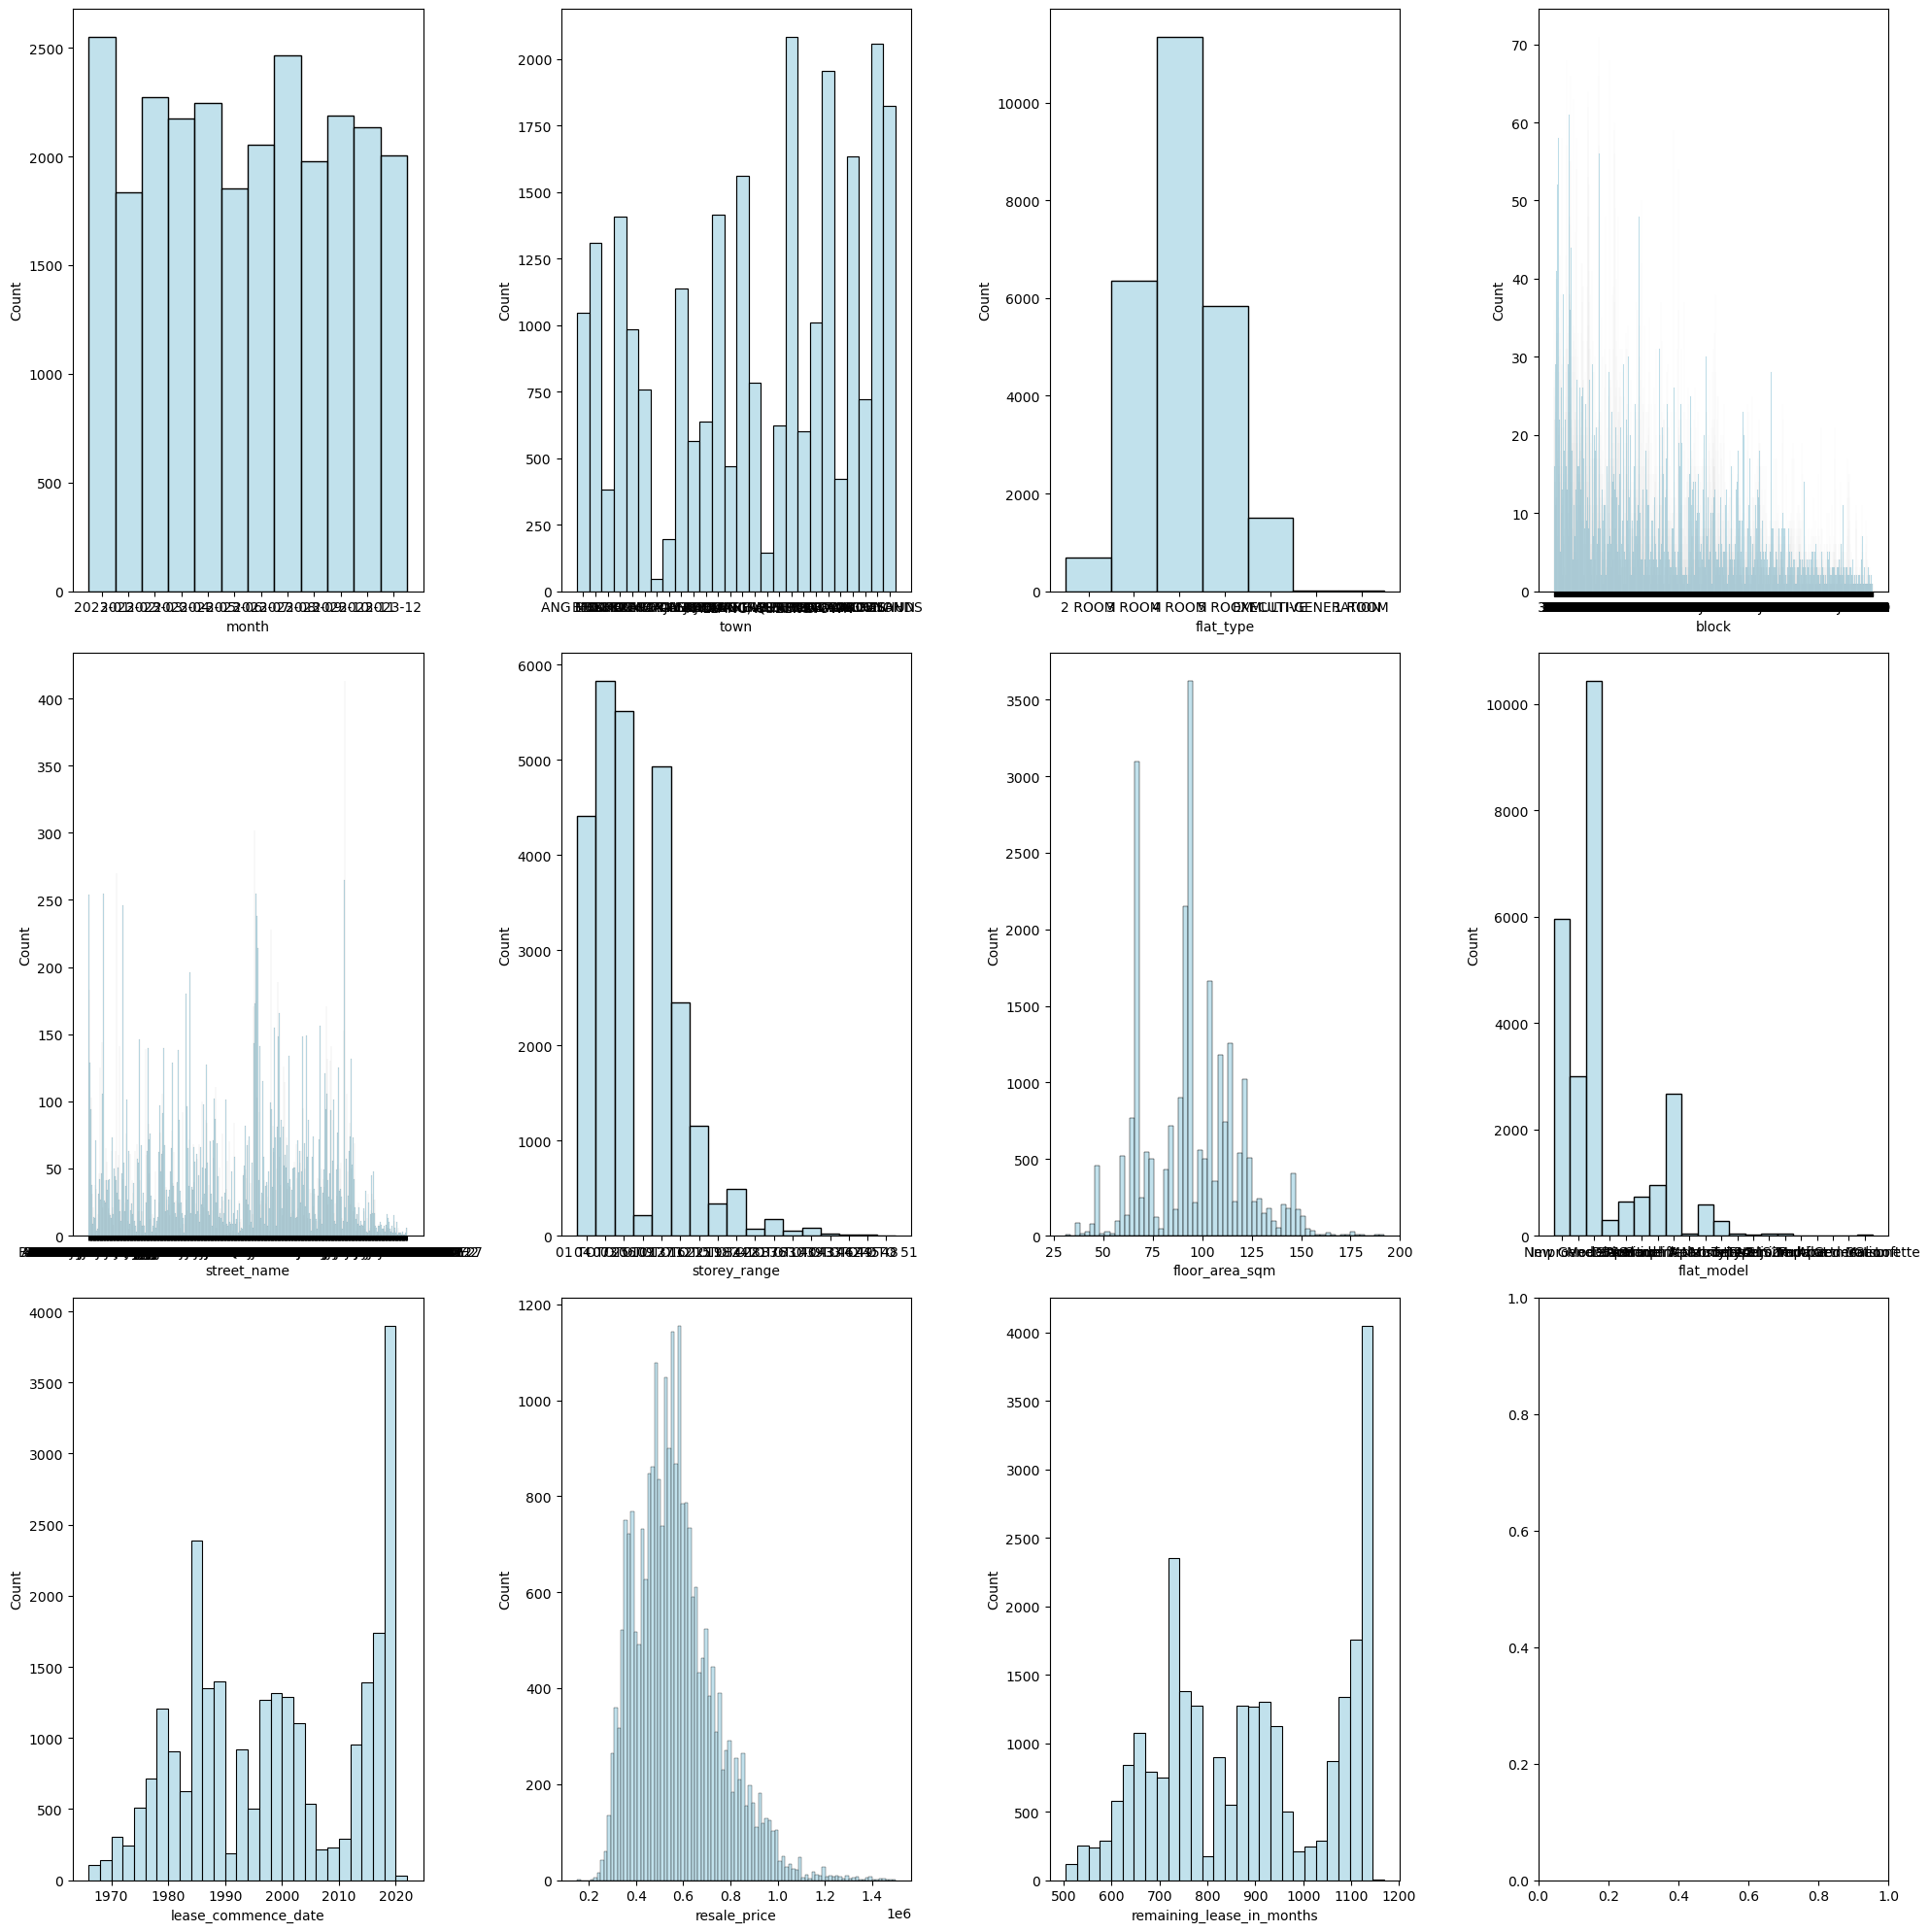

In [10]:

# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 20))

axes = axes.reshape(12,)

for i, col in enumerate(new_df_filtered.columns):
    sns.histplot(ax=axes[i],data=new_df_filtered,x=col,color='lightblue')
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Floor area sqm

lets first take a look at floor area sqm, this feature should be one of the more important feature that affects the pricing of the resale flats

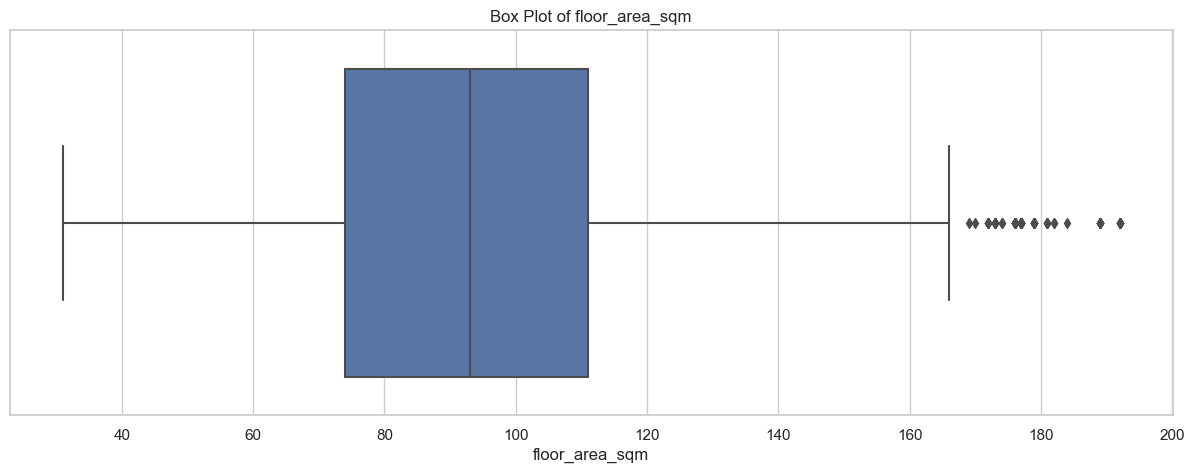

In [11]:
# Assuming 'resale_price' is the column you want to create a box plot for
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(15, 5))  # Set the size of the plot

df_column = 'floor_area_sqm'

# Create a box plot for the 'resale_price' column
sns.boxplot(x=new_df_filtered['floor_area_sqm'])

# Set plot title and labels
plt.title('Box Plot of floor_area_sqm')
plt.xlabel('floor_area_sqm')

# Show the plot
plt.show()


Looking at the box plot above, we can see that there are a few outliers which we will remove basing off of interquartile range removing any outliers that are outside of the lower and upper bounds.

In [12]:
# Identify outliers based on the box plot
q1 = new_df_filtered[df_column].quantile(0.25)
q3 = new_df_filtered[df_column].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove outliers
df_no_outliers = new_df_filtered[(new_df_filtered[df_column] >= lower_bound) & (new_df_filtered[df_column] <= upper_bound)]


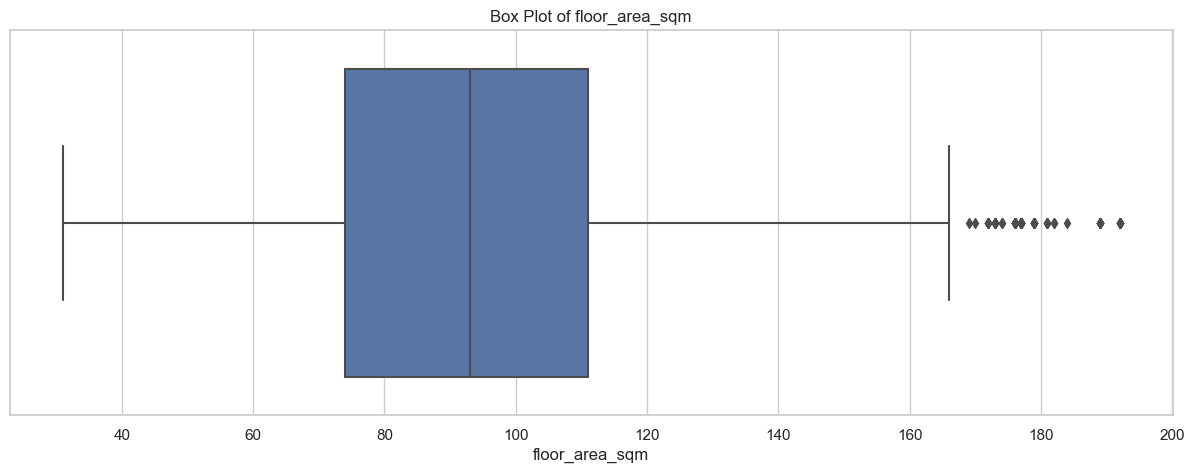

Mean: 95.11583666498466
Median: 93.0
Mode: ModeResult(mode=array([93.]), count=array([3032]))


/var/folders/sh/20gyz78x259b1zb5km266fq00000gn/T/ipykernel_53815/3935370243.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print('Mode: '+str(mode(new_df_filtered[df_column])))


In [13]:
#checking if most of the outliers are out

sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(15,5))  # Set the size of the plot


# Create a box plot for the 'resale_price' column
sns.boxplot(x=new_df_filtered[df_column])

# Set plot title and labels
plt.title('Box Plot of floor_area_sqm')
plt.xlabel('floor_area_sqm')

plt.show()

print('Mean: '+str(np.mean(new_df_filtered[df_column])))
print('Median: '+str(np.median(new_df_filtered[df_column])))
print('Mode: '+str(mode(new_df_filtered[df_column])))

With the functions above, we can see that the average floor area of the resale HDBs is 95.1 with the median being 93.0 and the most common resale HDB being 93sqm with a total of 3032 unit. 


#### Kurtosis

Kurtosis for floor_area_sqm: 0.03757870191702439
Skewness for floor_area_sqm: 0.250978788578148


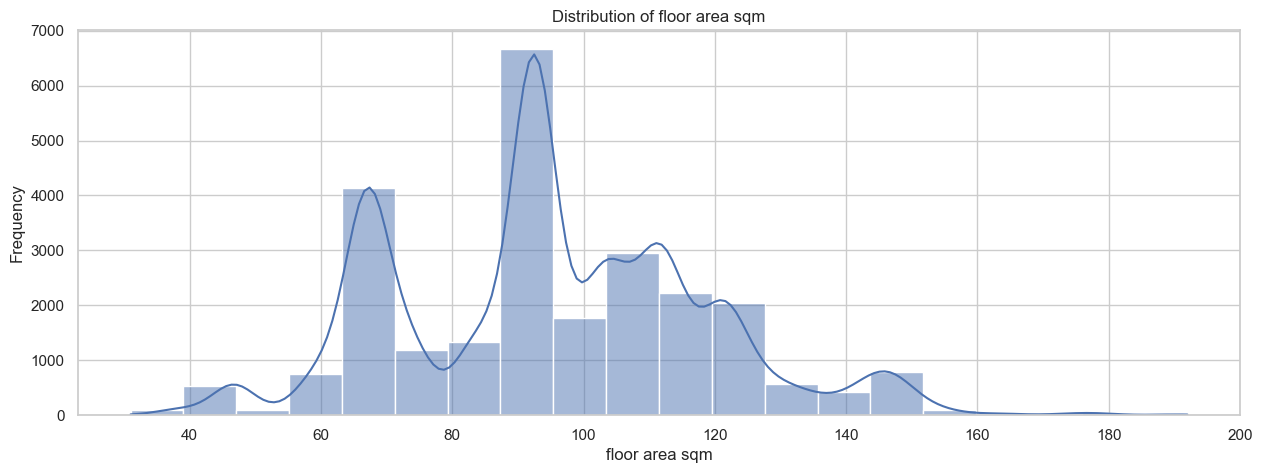

In [14]:
df_column = 'floor_area_sqm'


# Calculate kurtosis for the specified column
kurt = kurtosis(new_df_filtered[df_column])

# Print the kurtosis value
print(f'Kurtosis for {df_column}: {kurt}')

skewness = skew(new_df_filtered[df_column])

# Print the skewness value
print(f'Skewness for {df_column}: {skewness}')


# Visualize the distribution using a histogram
plt.figure(figsize=(15, 5))
sns.histplot(new_df_filtered[df_column],bins=20, kde=True)
plt.title('Distribution of floor area sqm')
plt.xlabel('floor area sqm')
plt.ylabel('Frequency')
plt.show()

Having a value of 0.037 kurtosis value indicates that floor area sqm has a platykurtic distribution which means that it has a flatter peak and lesser extreme outliers which implies that we do not need to mind too much about the outliers affecting the analysis.
Having a value of 0.251 skewness value means that the dataset is mainly symmetrical and just slightly skewed to the right.

### remaining lease in months

Next we will take a look at the remaining lease in months column and analyse any outliers, the measure of spread, central tendency and identify if there is any skewness that may be present

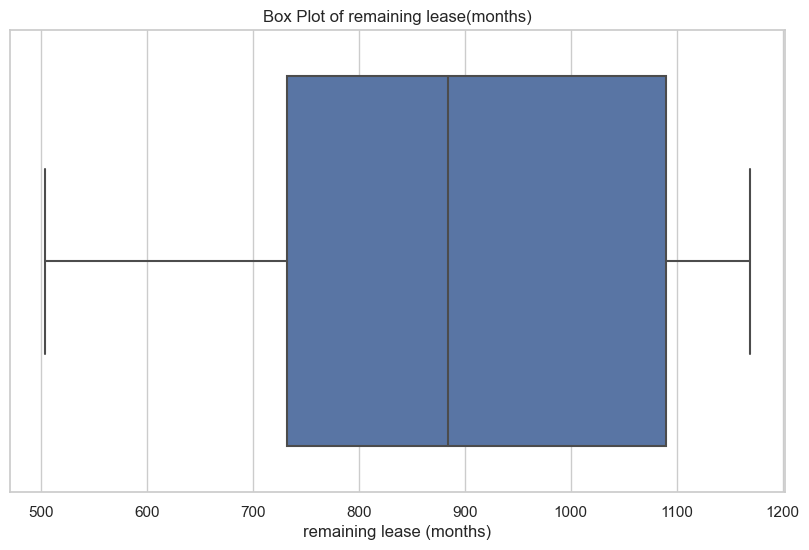

Mean: 888.8765283546171
Median: 884.0
Mode: ModeResult(mode=array([1128.]), count=array([357]))


/var/folders/sh/20gyz78x259b1zb5km266fq00000gn/T/ipykernel_53815/551143513.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print('Mode: '+ str(mode(new_df_filtered[df_column])))


In [15]:
# Assuming 'resale_price' is the column you want to create a box plot for
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Set the size of the plot

df_column = 'remaining_lease_in_months'

# Create a box plot for the 'resale_price' column
sns.boxplot(x=new_df_filtered[df_column])

# Set plot title and labels
plt.title('Box Plot of remaining lease(months)')
plt.xlabel('remaining lease (months)')




# Show the plot
plt.show()

print('Mean: ' + str(np.mean(new_df_filtered[df_column])))
print('Median: '+ str(np.median(new_df_filtered[df_column])))
print('Mode: '+ str(mode(new_df_filtered[df_column])))

With the function above, we have found out that the average lease remaing on the resale HDBs is 888.87 while the median is 884 months with the most number of resale flats having 1128 months left at 357 units.

Kurtosis for remaining_lease_in_months: -1.3014178746540552
Skewness for remaining_lease_in_months: -0.02408005502151981


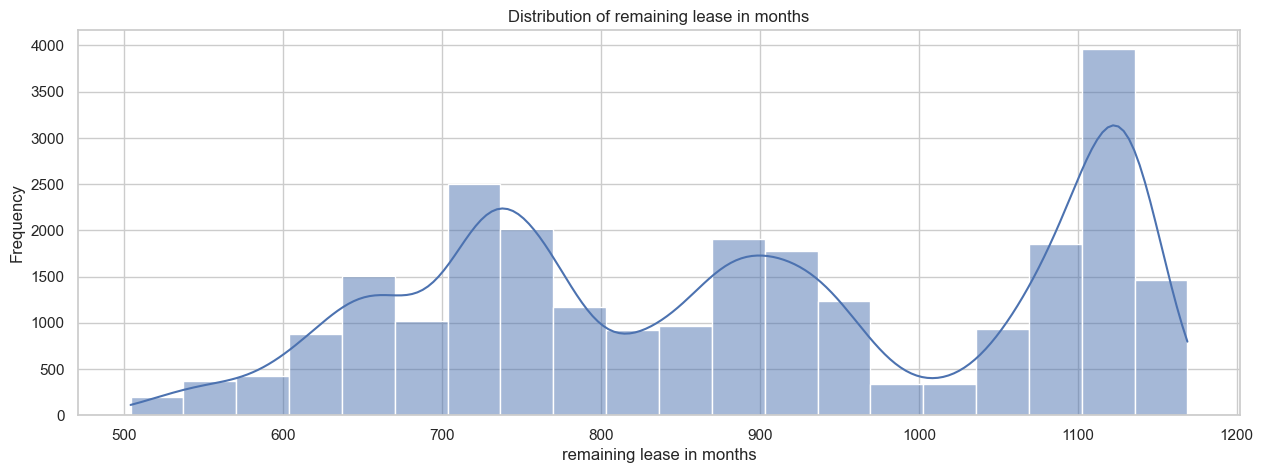

In [16]:
df_column = 'remaining_lease_in_months'


# Calculate kurtosis for the specified column
kurt = kurtosis(new_df_filtered[df_column])

# Print the kurtosis value
print(f'Kurtosis for {df_column}: {kurt}')

skewness = skew(new_df_filtered[df_column])

# Print the skewness value
print(f'Skewness for {df_column}: {skewness}')


# Visualize the distribution using a histogram
plt.figure(figsize=(15, 5))
sns.histplot(new_df_filtered[df_column],bins=20, kde=True)
plt.title('Distribution of remaining lease in months')
plt.xlabel('remaining lease in months')
plt.ylabel('Frequency')
plt.show()

Having a value of -1.3012 for kurtosis means that the dataset for remaining lease in month shave very few extreme outliers as we can see in the histogram above with a relatively flat peak. This means that the dataset is relatively consistent and requires little alteration.

### Resale Price

Next, we will look at our 

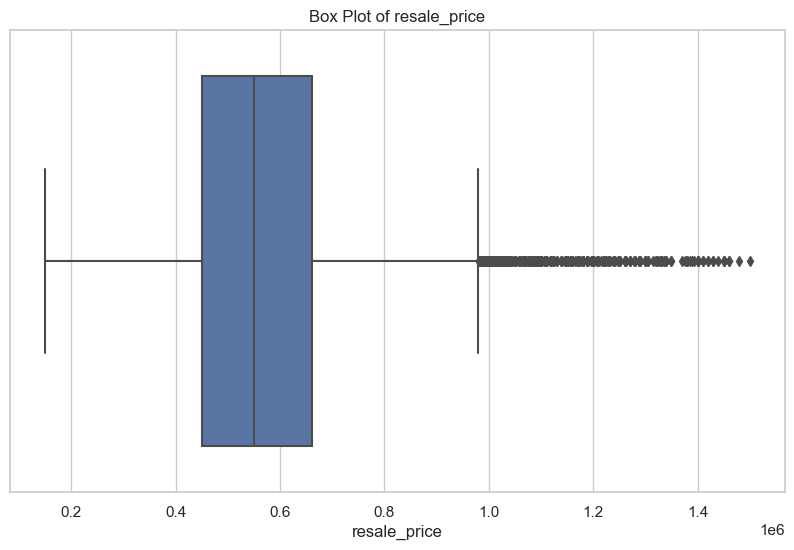

mean: 571785.7753149865
median: 550000.0
mode: ModeResult(mode=array([600000.]), count=array([359]))


/var/folders/sh/20gyz78x259b1zb5km266fq00000gn/T/ipykernel_53815/351227646.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print('mode: ' + str(mode(new_df_filtered[df_column])))


In [17]:
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Set the size of the plot

# Create a box plot for the 'resale_price' column
sns.boxplot(x=new_df_filtered['resale_price'])

df_column='resale_price'

# Set plot title and labels
plt.title('Box Plot of resale_price')
plt.xlabel('resale_price')

plt.show()


print('mean: '+ str(np.mean(new_df_filtered[df_column])))
print('median: ' + str(np.median(new_df_filtered[df_column])))
print('mode: ' + str(mode(new_df_filtered[df_column])))

Looking at the box plot above, the average resale price of HDB in 2023 is 571785 and the median is 550000 with the most number of resale flats being sold at 6000000 with a number of 359. 
However there are also many outliers in the resale_price dataset, however we cannot remove the outliers for the resale_price as there are many factors that results in the price of the HDB flat so not much alteration can be done to it.

Kurtosis for resale_price: 1.1795086403038892
Skewness for resale_price: 0.8997363514472025


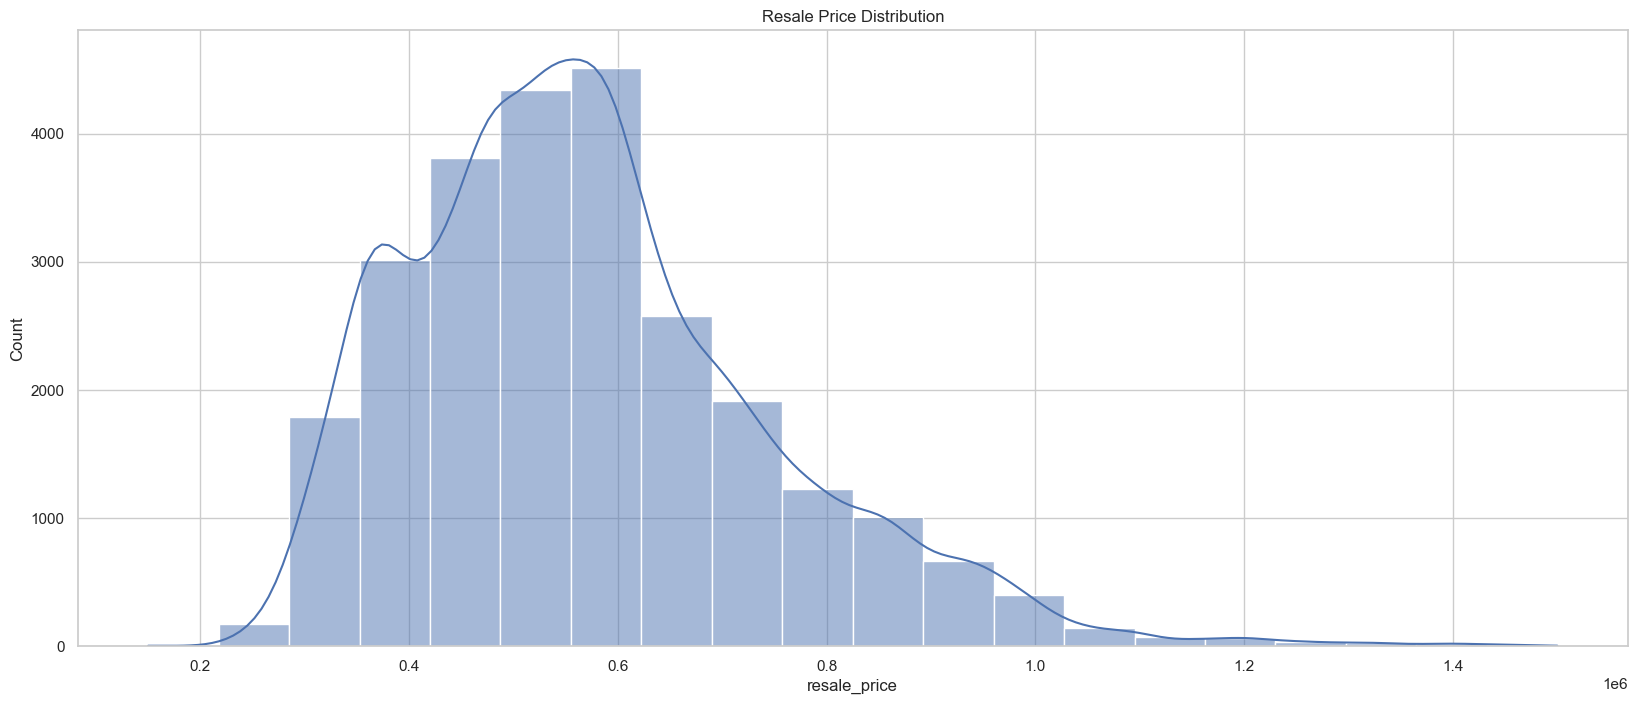

In [18]:
# Set up the figure and axis
fig, axes = plt.subplots(figsize=(20, 8))

df_column='resale_price'

# Calculate kurtosis for the specified column
kurt = kurtosis(new_df_filtered[df_column])

# Print the kurtosis value
print(f'Kurtosis for {df_column}: {kurt}')


skewness = skew(new_df_filtered[df_column])

# Print the skewness value
print(f'Skewness for {df_column}: {skewness}')


# Plot the histogram for 'resale_price'
sns.histplot(new_df_filtered[df_column], bins=20, kde=True, ax=axes)
axes.set_title('Resale Price Distribution')

# Show the plot
plt.show()

Having a positive kurtosis means that the distribution has heavier tails and a sharp peak which indicates a leptokurtic distribution. This means that there are more extreme outlies thna expected in a normal distribution. This is known from above as seen in the box plot where there is a large number of outliers .
with a positive skewness, 

### Identifying outliers

looking at flat_model, we can identify if there are any particular models that are too low to be of any use in the dataset and remove them allowing the linear regression model to be better later on.

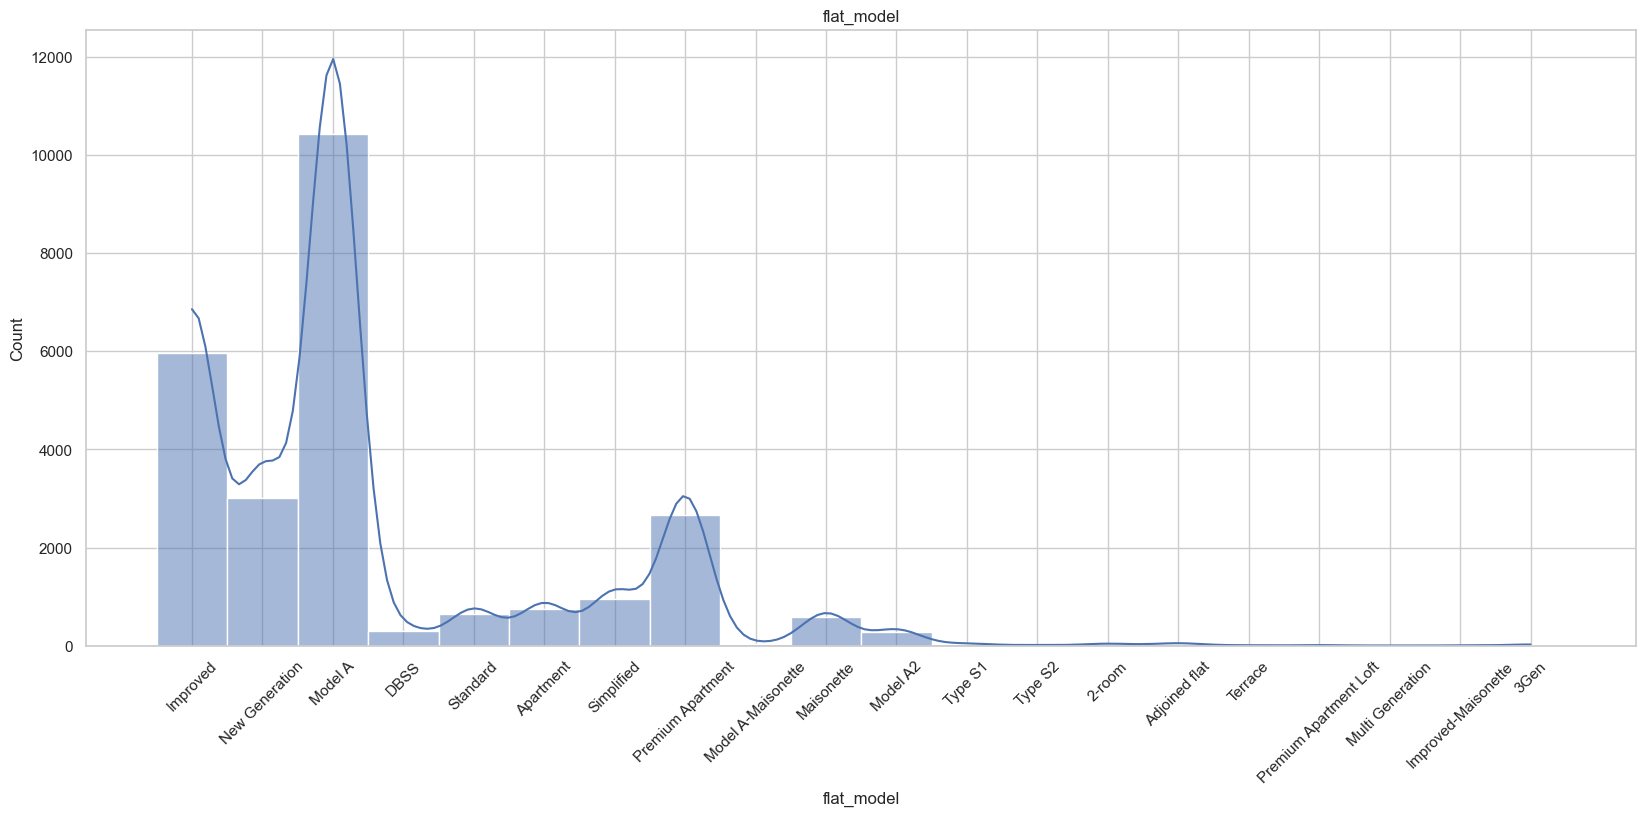

In [19]:
# Set up the figure and axis
fig, axes = plt.subplots(figsize=(20, 8))

# Plot the histogram for 'resale_price'
sns.histplot(new_df_filtered['flat_model'], bins=40, kde=True, ax=axes)
axes.set_title('flat_model')
plt.xticks(rotation=45)


# Show the plot
plt.show()

In [20]:
#here we drop the flat_models that contain little to no datasets.
new_df_filtered = new_df_filtered[~new_df_filtered['flat_model'].isin(['Model A-Maisonette', 'Type S1', 'Type S2','2-room','Adjoined flat','Terrace','Premium Apartment Loft','Improved-Maisonette','3Gen'])]

### Flat_type

In order to visualise the number of flat_type and how it affects the resale price, a violin plot is used to visualise the data

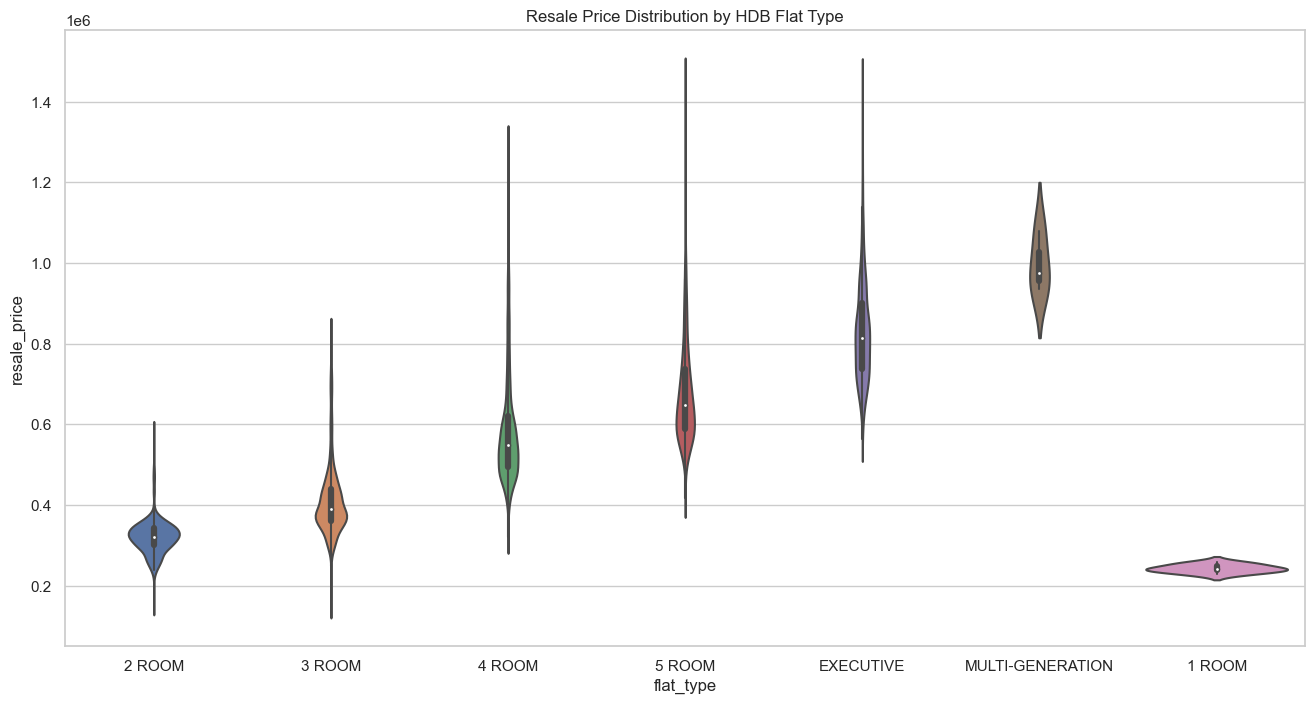

In [21]:
# Set up the figure and axis

plt.figure(figsize=(16, 8))
sns.violinplot(data=new_df_filtered, x='flat_type', y='resale_price')
plt.title('Resale Price Distribution by HDB Flat Type')
plt.show()

Looking at the violin plot, we are able to visualise the different flat_types and how much they get normally sold for.

### Preparing the flat_type data for linear regression

In [22]:

#make a copy of the dataset
new_df_temp = new_df_filtered.copy()


for col in new_df_temp.columns:
    new_df_temp[col] = new_df_temp[col].replace({'1 ROOM' : 0,'2 ROOM': 1,'3 ROOM' :2, '4 ROOM':3, '5 ROOM' :4, 'EXECUTIVE' :5, 'MULTI-GENERATION' :6})

#changing the datatypes to numeric
new_df_temp['flat_type'] = pd.to_numeric(new_df_temp['flat_type'], errors='coerce')


new_df_temp.describe()

,flat_type,floor_area_sqm,lease_commence_date,resale_price,remaining_lease_in_months
count,25555.000000,25555.000000,25555.000000,2.555500e+04,25555.000000
mean,3.041323,94.996286,1998.008726,5.694076e+05,888.801996
std,0.900122,23.417083,15.057092,1.701105e+05,181.166546
min,0.000000,31.000000,1966.000000,1.500000e+05,504.000000
25%,2.000000,74.000000,1985.000000,4.500000e+05,732.000000
50%,3.000000,93.000000,1998.000000,5.500000e+05,884.000000
75%,4.000000,110.000000,2015.000000,6.600000e+05,1090.000000
max,6.000000,192.000000,2022.000000,1.460000e+06,1169.000000


<AxesSubplot:>

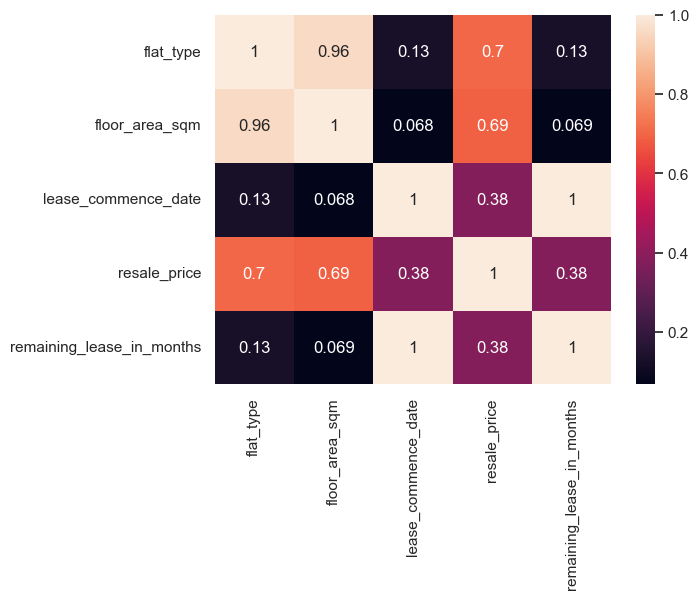

In [23]:
sns.heatmap(new_df_temp.corr(),annot=True)

Looking at the heatmap, we can see some factors have higher correlation to each other, as such we are not able to use them together in the linear regression model, such example are floor_area_sqm and flat_type, and lease_commence_date and remaining_lease_in_months.

## Linear Regression

In [24]:
X = new_df_temp[['floor_area_sqm','remaining_lease_in_months']]
y= new_df_temp['resale_price']

In [25]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=57)

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score , make_scorer

In [27]:
lm=LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

[]

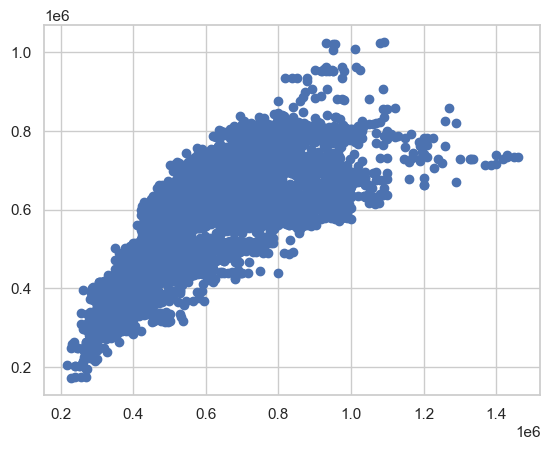

In [28]:
plt.scatter(y_test,y_pred)
plt.plot()

/Users/lohqiyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='resale_price', ylabel='Density'>

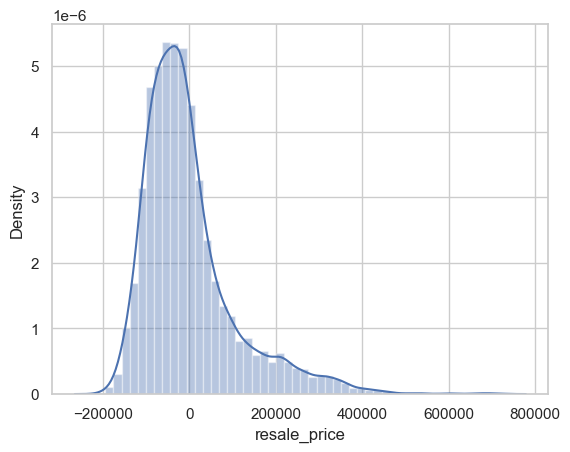

In [29]:
sns.distplot((y_test-y_pred),bins=50)

In [30]:
print('coef:')
print(lm.coef_)
print('R2 score:')
print(r2_score(y_test,y_pred))
print('mean absolute error:')
print(mean_absolute_error(y_test,y_pred))


coef:
[4832.12836116  311.67144066]
R2 score:
0.5886419633765563
mean absolute error:
78635.25955601313


## Validation

In [31]:
from sklearn.model_selection import cross_val_score, KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation with Mean Absolute Error
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
scores_mae = cross_val_score(lm, X, y, scoring=mae_scorer, cv=kfold)

# Evaluate Results
mean_mae = -scores_mae.mean()  # Note the negation since cross_val_score returns negative values for the scorer
std_dev_mae = scores_mae.std()
    
print(f'Mean Cross-Validation MAE: {mean_mae}')
print(f'Standard Deviation of MAE Scores: {std_dev_mae}')

Mean Cross-Validation MAE: 78917.06318865236
Standard Deviation of MAE Scores: 646.3096818175375


## Feature Engineering

To further improve the dataset, some modifications have to be made to the dataset such as intruding the storey range as a new feature to train the model, storey range may affect teh model significantly as people tend to have preferences over how high up they live in as such we will do some modifications to the dataset so as to change the datatype of the storey_range from an object to a numeric data type.

As the storey_range is a range of values we will take the median of the values to be the caluclated value of the data.

In [32]:
def convert_range_to_median(range_str):
    start, end = map(int, range_str.split(' TO '))
    return (start + end) / 2

# Apply the conversion function to the 'story_range' column
new_df_temp['storey_range'] = new_df_temp['storey_range'].apply(convert_range_to_median)


We will introduce another feature which utilises two features by calculating resale_price and floor_area_sqm and gettting the price per sqm for better feature scaling.

In [33]:
#new data column
new_df_temp['price_per_sqm'] = new_df_temp['resale_price']/new_df_temp['floor_area_sqm']

<AxesSubplot:>

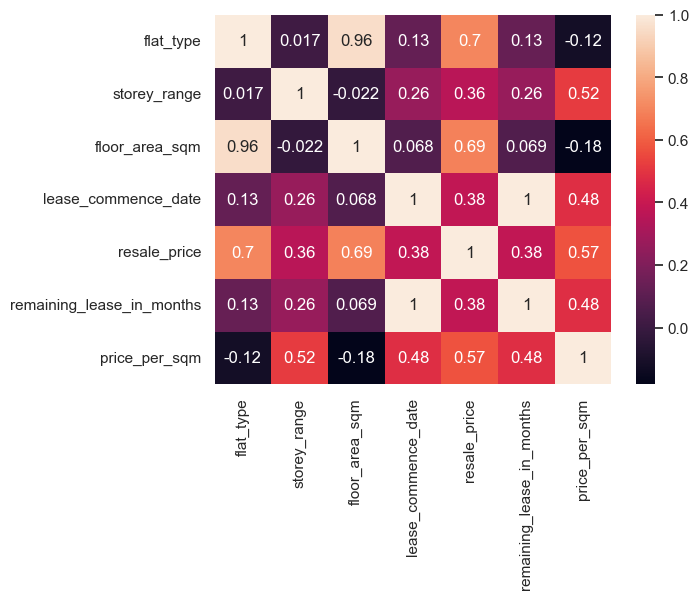

In [34]:
sns.heatmap(new_df_temp.corr(),annot=True)

In [35]:
X = new_df_temp[['floor_area_sqm','remaining_lease_in_months','storey_range','price_per_sqm']]
y= new_df_temp['resale_price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=57)
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)


[]

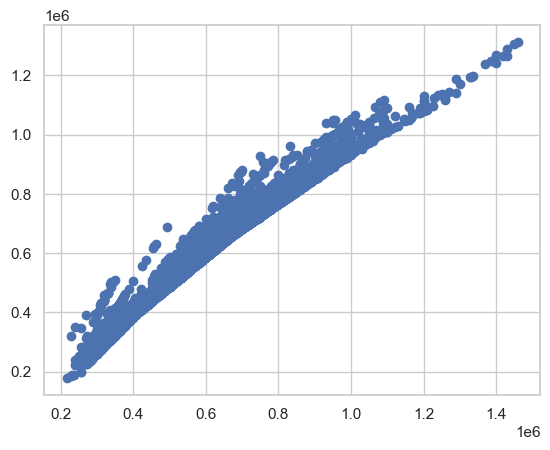

In [36]:
plt.scatter(y_test,y_pred)
plt.plot()

/Users/lohqiyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='resale_price', ylabel='Density'>

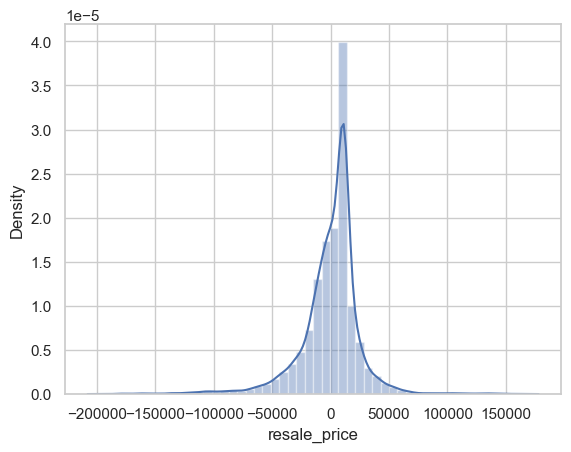

In [37]:
sns.distplot((y_test-y_pred),bins=50)

In [38]:
print('coef:')
print(lm.coef_)
print('R2 Score:')
print(r2_score(y_test,y_pred))
print('mean absolute error:')
print( mean_absolute_error(y_test,y_pred))

coef:
[5994.22458003  -28.83593656   51.33624489   93.52550051]
R2 Score:
0.9762491880907106
mean absolute error:
17340.458816900198


With this new feature, we have improved the linear regression model by increasing the r2 score by 0.4 and decreasing the mean absolute error by 60000+, allowing the linear regression model to be better at predicting the prices.

## Evaluation
In terms of evaluating the model, the scoring metrics that I have chosen is the R2 score and the mean abolute error. With R2 score, we are able to evaluate the accuracy of the model in predicting the dataset and with mean absolute error, as the dataset that I am looking at is that ouf HDB resale prices, there may be extreme outliers due to the nature of the house pricing being unprecitable and there may be personal and financial decision which may affect the pricing.

Before feature engineering, with the linear regression model, the model achieved a z-score of 0.578 and a mean absolute error of 80,478, this means that the linear regression model before feature engineering had a 57% accurar\cy in predicting the dataset and a 80,478 deviation of error, which in this context of resale HDB is still considered normal as the prices ranges for few hundred thousand to millions.

With feature engineering, the model improved to a z-score of 0.97 and a mean absolute error of 17,542, thi means that feature engineering has helped further improved the accuracy of the model from 57% to 97% and reduce the deivation of error to 17,542.

With this model, people who are intending to get their own HDB resale flat or intending to sell their resale flat can better understand the reason behind pricing and how much they can get a flat or sell a flat for.

The Singapore government can also use this model to plan out further housing development projects allowing for its citizens to get more affordable flats.